
# Quantum Support Vector Machine (QSVM) Implementation and Performance Analysis




## 1. Introduction
Quantum Machine Learning (QML) promises to transform image classification by lever-
aging quantum mechanics’ computational advantages. This project focuses on using
Quantum Support Vector Machines (QSVM) to process the MNIST dataset, a standard
benchmark in the machine learning community. By employing QSVM, we aim to demon-
strate the potential of quantum computing to streamline and accelerate the classification
process.


The primary goal of this project is to demonstrate how QSVM achieves better accuracy compared to classical SVMs on the same dataset, especially for non-linear class separations.

## 2. Libraries Used

This project leverages the following libraries to implement, simulate, and evaluate the Quantum Support Vector Machine (QSVM) and compare its performance to classical SVMs:

### **Quantum Libraries**
1. **Qiskit**: A comprehensive quantum computing framework used to:
   - Simulate quantum circuits using the `AerSimulator` and `QasmSimulator`.
   - Encode classical data into quantum states via feature maps like **ZZFeatureMap**.
   - Compute quantum kernels for QSVM using the **FidelityQuantumKernel**.
   - Train and evaluate quantum models, including QSVM and trainable quantum kernels.

### **Machine Learning Libraries**
2. **scikit-learn**: A widely-used Python library for classical machine learning, utilized to:
   - Train the classical Support Vector Machine (SVM) as a baseline model.
   - Evaluate model performance using metrics like accuracy and classification reports.
   - Scale and preprocess data with tools like `StandardScaler`.

3. **imbalanced-learn**: A Python library for handling imbalanced datasets:
   - Used **SMOTE (Synthetic Minority Oversampling Technique)** to balance datasets for training.

### **Visualization Libraries**
4. **Matplotlib**: A versatile plotting library used to:
   - Visualize datasets, including synthetic and ad-hoc datasets.
   - Plot decision boundaries for QSVM and classical SVM models.
   - Explore the structure of quantum kernel matrices.

### **Numerical Computing**
5. **NumPy**: A fundamental library for numerical computations, used to:
   - Handle matrix operations required for kernel construction.
   - Generate synthetic datasets and manipulate high-dimensional data.
   - Randomly initialize parameters for trainable quantum kernels.

### **Data Manipulation**
6. **Pandas**: A data analysis library used for:
   - Managing and preprocessing tabular datasets.
   - Exploring and transforming structured data.


In [1]:
# === Standard Library Imports ===
import os
import time
import logging

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Scikit-learn Imports ===
from sklearn import datasets
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# === Qiskit Imports ===
# Core Qiskit libraries
from qiskit import Aer, QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.circuit import ParameterVector

# Qiskit Aer
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler, SamplerV2, Estimator

# Qiskit Machine Learning
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel, TrainableKernel
from qiskit_machine_learning.kernels.fidelity_quantum_kernel import ComputeUncompute
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.utils.loss_functions import SVCLoss

## Load the dataset
link to the dataset: https://www.kaggle.com/datasets/luyezhang/heart-2020-cleaned



In [15]:
# Load and sample the dataset
data = pd.read_csv('heart_2020_cleaned.csv')
data = data.sample(n=200, random_state=42)

# Inspect the first few rows to understand the data structure
print(data.head())

# Preprocessing: Convert categorical variables to numeric
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column].astype(str))
    label_encoders[column] = le

# Assuming 'HeartDisease' is the target variable
target = 'HeartDisease'

# Split the dataset into features and the target variable
X = data.drop(target, axis=1)
y = data[target]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (unbalanced)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Balance the training set using SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)  # Default for training set
X_train, y_train = smote.fit_resample(X_train, y_train)

# Balance the testing set using SMOTE with adjusted n_neighbors
minority_class_count = y_test.value_counts().min()
n_neighbors_test = min(5, minority_class_count - 1)  # Ensure n_neighbors < minority class samples
smote_test = SMOTE(random_state=42, k_neighbors=n_neighbors_test)

X_test, y_test = smote_test.fit_resample(X_test, y_test)

# Verify the new class distributions
print("Class distribution in the training set before balancing:")
print(y_train.value_counts())
print("Class distribution in the training set after balancing:")
print(pd.Series(y_train).value_counts())

print("Class distribution in the testing set before balancing:")
print(y_test.value_counts())
print("Class distribution in the testing set after balancing:")
print(pd.Series(y_test).value_counts())

# Final shapes of the balanced datasets
print(f"Balanced Training set shape: {X_train.shape}, Balanced Testing set shape: {X_test.shape}")

       HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
271884           No  27.63     Yes              No     No             0.0   
270361           No  21.95      No              No     No             0.0   
219060           No  31.32     Yes              No     No             0.0   
24010            No  40.35      No              No     No            30.0   
181930           No  35.61     Yes              No     No            30.0   

        MentalHealth DiffWalking     Sex AgeCategory      Race Diabetic  \
271884          25.0          No  Female       25-29  Hispanic       No   
270361          20.0          No  Female       30-34     White       No   
219060           0.0          No  Female       40-44     White       No   
24010            0.0          No  Female       65-69     White       No   
181930          30.0         Yes  Female       60-64     White       No   

       PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
271884

## 3. Classical SVM: Explanation

Support Vector Machines (SVMs) aim to find the optimal hyperplane that maximizes the margin between two classes. The optimization problem for a binary classification task is:

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2
$$

Subject to:

$$
y_i (\mathbf{w}^\top \phi(\mathbf{x}_i) + b) \geq 1 \quad \forall i,
$$

### **Dual Form**
The dual form of the optimization problem, useful for kernel-based SVMs, is:

$
\max_{\boldsymbol{\alpha}} \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i,j=1}^N \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j),
$

Subject to:

$$
\sum_{i=1}^N \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C,
$$

### **Kernel Trick**
To handle non-linear data, the SVM uses the kernel trick, where common kernels include:
- **Linear**: $K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^\top \mathbf{x}_j$.
- **Polynomial**: $K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i^\top \mathbf{x}_j + 1)^d$.
- **RBF**: $K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2}\right)$.

### **Decision Function**
The decision function for a new data point $\mathbf{x}$ is:

$$
f(\mathbf{x}) = \text{sign}\left(\sum_{i=1}^N \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b\right).
$$

### **Baseline Implementation**
In this project, we use an SVM with an RBF kernel as the baseline to compare against the QSVM.

## Example usage of Classical SVM

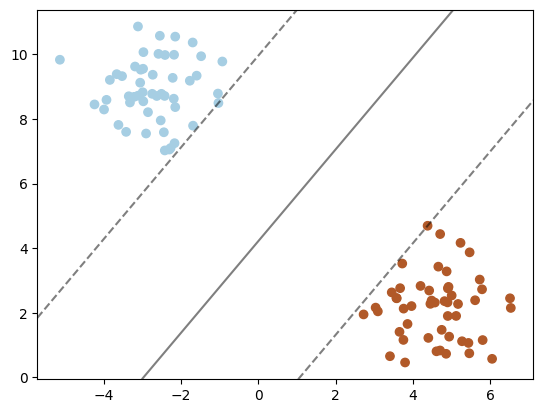

In [4]:

from sklearn.datasets import make_blobs


# Create synthetic data
X, y = make_blobs(n_samples=100, centers=2, random_state=42)
y = 2 * y - 1  # Convert labels to {-1, 1}

# Train SVM
svm = SVC(kernel='linear', C=1)
svm.fit(X, y)

# Plot decision boundary
def plot_svm(svm, X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = svm.decision_function(xy).reshape(XX.shape)

    # Plot decision boundary
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    plt.show()

plot_svm(svm, X, y)

## Implementation of Classical SVM


In [5]:
def classical_svm(X_train, X_test, y_train, y_test, kernel='rbf', scale_data=False, verbose=False):
    """
    Train and evaluate a classical Support Vector Machine with optional data scaling.
    
    Args:
        X_train, X_test (array-like): Training and testing feature sets.
        y_train, y_test (array-like): Training and testing labels.
        kernel (str): Kernel type for the SVM. Default is 'rbf'.
        scale_data (bool): If True, scale features before training. Default is False.
        verbose (bool): If True, print additional details during processing. Default is False.
    
    Returns:
        Dictionary with performance metrics and training time.
    """
    start_time = time.time()
    
    # Optionally scale the data
    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        if verbose:
            print("Data scaling applied.")
    
    # Create and train SVM
    svm_classifier = SVC(kernel=kernel)
    svm_classifier.fit(X_train, y_train)
    
    if verbose:
        print("SVM training completed.")
    
    # Predict and evaluate
    y_pred = svm_classifier.predict(X_test)
    end_time = time.time()
    
    # Prepare the performance metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'training_time': end_time - start_time,
        'classification_report': classification_report(y_test, y_pred, output_dict=True)
    }
    
    if verbose:
        print(f"Classification Report:\n {classification_report(y_test, y_pred)}")
    
    return metrics



## 4. Quantum SVM (QSVM) with Fidelity Quantum Kernel

This section introduces the Quantum Support Vector Machine (QSVM) using the Fidelity Quantum Kernel. QSVM leverages quantum feature mapping to encode classical data into quantum states and uses a classical SVM algorithm for classification. The combination of quantum kernels and classical optimization enables the QSVM to capture complex, non-linear relationships in data.

### **Quantum Feature Map**

The **ZZFeatureMap** is a quantum feature mapping technique that encodes classical data into quantum states. It applies a combination of parameterized quantum gates and entanglement operations to create a high-dimensional representation of the input data in the quantum Hilbert space. The process introduces correlations between features using entanglement gates such as $R_{ZZ}$.

For more details about the implementation of the **ZZFeatureMap** and its role in quantum kernel computation, refer to the [IBM Quantum Documentation](https://quantum-computing.ibm.com/lab/docs/iqx/algorithms/machine-learning/quantum-kernel-alignment).

---

### **Note**
In this project, the Fidelity Quantum Kernel is built using the **ZZFeatureMap**, which measures the similarity between quantum states by calculating their fidelity. The resulting kernel matrix is passed to a classical SVM for training and classification.

#### **Circuit for ZZFeatureMap**
Below is an example circuit for a 3-qubit ZZFeatureMap with full entanglement:

In [6]:


# Create a ZZFeatureMap with full entanglement for 3 qubits
feature_map = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='full')

# Display the decomposed circuit
print(feature_map.decompose())

     ┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     └───┘└─────────────┘                                          └───┘»
«                                               »
«q_0: ──────────────────────────────────■───────»
«                                       │       »
«q_1: ──────────────────────────────────┼────■──»
«     ┌──────────────────────────────┐┌─┴─┐┌─┴─┐»
«q_2: ┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├»
«     └──────────────────────────────┘└───┘└───┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          


Below is an example circuit for a 3-qubit ZZFeatureMap with linear entanglement:


In [16]:
# Create a ZZFeatureMap with full entanglement for 3 qubits
feature_map = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')

# Display the decomposed circuit
print(feature_map.decompose())

     ┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■───────»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐     »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     └───┘└─────────────┘                                          └───┘»
«                                          
«q_0: ─────────────────────────────────────
«                                          
«q_1: ──────────────────────────────────■──
«     ┌──────────────────────────────┐┌─┴─┐
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├
«     └──────────────────────────────┘└───┘


#  ZZFeatureMap

## 1. Initial Hadamard Gates
Each qubit is initialized in the $|0\rangle$ state. Applying a Hadamard gate transforms the state to a uniform superposition:

$$
H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$$

For 2 qubits ($q_0$ and $q_1$), the initial state becomes:

$$
\frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)
$$

---

## 2. Data Encoding with $R_Z(\theta)$
The $R_Z(\theta)$ gate applies a phase rotation based on the input data ($\theta$):

$$
R_Z(\theta) = \begin{bmatrix}
1 & 0 \\
0 & e^{i\theta}
\end{bmatrix}
$$

After applying $R_Z(\theta[0])$ to $q_0$ and $R_Z(\theta[1])$ to $q_1$, the state becomes:

$$
\frac{1}{2}\left(|00\rangle + e^{i\theta[1]}|01\rangle + e^{i\theta[0]}|10\rangle + e^{i(\theta[0]+\theta[1])}|11\rangle\right)
$$

---

## 3. Entanglement with $CZ$
The controlled-Z ($CZ$) gate introduces pairwise entanglement. Its matrix representation is:

$$
CZ = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{bmatrix}
$$

The $CZ$ gate applies a $-1$ phase to the $|11\rangle$ state. After applying $CZ$ between $q_0$ and $q_1$, the state becomes:

$$
\frac{1}{2}\left(|00\rangle + e^{i\theta[1]}|01\rangle + e^{i\theta[0]}|10\rangle - e^{i(\theta[0]+\theta[1])}|11\rangle\right)
$$

---

## 4. Interaction Terms via $R_Z(2 \cdot \text{interaction})$
An additional $R_Z$ gate applies interaction terms between features:

$$
R_Z(2 \cdot (\pi - x[0]) \cdot (\pi - x[1]))
$$

This gate modifies the phase of the state based on pairwise feature interaction terms. The final state becomes:

$$
\frac{1}{2}\left(|00\rangle + e^{i\theta[1]}|01\rangle + e^{i\theta[0]}|10\rangle - e^{i(2(\pi - x[0])(\pi - x[1]) + \theta[0] + \theta[1])}|11\rangle\right)
$$

---



## QasmSimulator: Interpretation and Role in QSVM Training

The **QasmSimulator** from Qiskit Aer is a powerful quantum circuit simulator that emulates the behavior of a quantum device by simulating quantum measurements. In the context of QSVM training, the QasmSimulator is used to compute the quantum kernel, enabling the evaluation of the Quantum Support Vector Machine (QSVM) without relying on physical quantum hardware.

1. **Quantum Measurement Simulation**:  
   - The QasmSimulator performs simulated quantum measurements based on the circuit's state after execution.  
   - This allows it to mimic the probabilistic nature of quantum devices, providing insights into how the QSVM would perform on real quantum hardware.

2. **Kernel Matrix Construction**:  
   - QSVM relies on constructing a kernel matrix, where the entries are computed based on the fidelity between quantum states:  
     $$
     K(x_i, x_j) = |\langle \psi(x_i) | \psi(x_j) \rangle|^2.
     $$  
   - The QasmSimulator performs this computation by executing the quantum circuit for each pair of data points, sampling measurement results over multiple shots.

3. **No Access to Physical Hardware Needed**:  
   - By using the QasmSimulator, QSVM can be trained and evaluated locally without requiring access to noisy or resource-constrained quantum hardware.

4. **Control over Shots**:  
   - The number of shots determines the precision of the measurement outcomes. By default, QSVM training with the QasmSimulator uses a sufficient number of shots (e.g., 1024) to ensure accurate fidelity computation:  
     $$
     \text{Fidelity} = \frac{\text{Matching Measurement Outcomes}}{\text{Total Shots}}.
     $$


## Quantum Kernel: Calculation and Comparison to Traditional Kernels

A quantum kernel measures the similarity between quantum states representing classical data. It is a fundamental building block of Quantum Support Vector Machines (QSVMs), enabling the QSVM to classify data by leveraging quantum feature spaces. The quantum kernel is particularly powerful for datasets with non-linear patterns, where traditional kernels may struggle to find an optimal mapping.


### **Quantum Kernel Calculation in This Implementation**
In this project, the **FidelityQuantumKernel** computes the kernel matrix, where each element represents the fidelity (overlap) between two quantum states. Below is a step-by-step explanation:

#### 1. **Data Encoding**
The classical data points $\mathbf{x}_i$ and $\mathbf{x}_j$ are encoded into quantum states using the **ZZFeatureMap**:
$$
\lvert \psi(\mathbf{x}_i) \rangle = U_{\phi}(\mathbf{x}_i) \lvert 0 \rangle^{\otimes n}, \quad \lvert \psi(\mathbf{x}_j) \rangle = U_{\phi}(\mathbf{x}_j) \lvert 0 \rangle^{\otimes n}.
$$
Here:
- $U_{\phi}(\mathbf{x})$ is the unitary transformation defined by the ZZFeatureMap, which uses $RZ$ gates and entanglement operations to encode the data.

#### 2. **Kernel Value Calculation**
The kernel value for two data points $\mathbf{x}_i$ and $\mathbf{x}_j$ is the square of the absolute value of the inner product (fidelity) of their corresponding quantum states:
$$
K(\mathbf{x}_i, \mathbf{x}_j) = \lvert \langle \psi(\mathbf{x}_i) \vert \psi(\mathbf{x}_j) \rangle \rvert^2.
$$
This measures the similarity between the quantum states and captures the relationships between the encoded data points in the high-dimensional quantum feature space.

#### 3. **Kernel Matrix Construction**
The kernel matrix $K$ is computed for all pairs of training data points:
$$
K_{ij} = \lvert \langle \psi(\mathbf{x}_i) \vert \psi(\mathbf{x}_j) \rangle \rvert^2.
$$
For $N$ training samples, this results in an $N \times N$ kernel matrix, which is passed to the classical SVM for optimization.

---

### Quantum kernel

The quantum kernel maps classical data into a high-dimensional quantum Hilbert space. This process enables the QSVM to:
1. **Capture Non-linear Relationships**: Quantum feature maps can represent complex, non-linear patterns in data more effectively than traditional kernels.
2. **Expand Feature Space**: The quantum kernel implicitly operates in a feature space with exponentially many dimensions, providing a richer 
---

### **Comparison to Traditional Kernels**

| **Aspect**           | **Quantum Kernel**                                                                                           | **Traditional Kernel**                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------|
| **Feature Space**     | Operates in a high-dimensional quantum Hilbert space.                                                       | Operates in a finite-dimensional feature space defined by the kernel function.                           |
| **Mapping Complexity**| Implicitly maps data to an exponentially large feature space.                                                | Depends on the kernel function (e.g., RBF, polynomial).                                                   |
| **Similarity Measure**| Measures the fidelity between quantum states, capturing both local and global relationships in data.         | Measures similarity using mathematical functions (e.g., Euclidean distance for RBF, dot product for linear).|
| **Kernel Function**   | $K(\mathbf{x}_i, \mathbf{x}_j) = \lvert \langle \psi(\mathbf{x}_i) \vert \psi(\mathbf{x}_j) \rangle \rvert^2$ | RBF Kernel: $K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2}\right)$ |
| **Computation**       | Requires a quantum circuit simulator or quantum hardware for state preparation and overlap measurement.      | Computed entirely on classical hardware using closed-form equations.                                     |
| **Expressivity**      | Can capture complex, entangled relationships in data due to quantum superposition and entanglement.          | Limited by the expressive power of the chosen kernel (e.g., linear, polynomial, RBF).                    |


### **References**
1. IBM Quantum Documentation: [Quantum Kernels](https://quantum-computing.ibm.com/lab/docs/iqx/algorithms/machine-learning/quantum-kernel-alignment)
2. Qiskit Machine Learning Documentation: [Fidelity Quantum Kernel](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.FidelityQuantumKernel.html)

### Example usage of quantum kernel

In [7]:
# example usage of quantum kernel
data1= np.array([
    [0.1, 0.2],  
    [0.3, 0.4],  
    [0.5, 0.6]   
])
feature_map = ZZFeatureMap(feature_dimension=2, reps=1)
quantum_kernel = FidelityQuantumKernel(
        feature_map=feature_map,
        fidelity=None,  
        enforce_psd=True,
        evaluate_duplicates='off_diagonal',
        max_circuits_per_job=None
    )
kernel_matrix = quantum_kernel.evaluate(x_vec=data1)
print("Quantum Kernel Matrix:")
print(kernel_matrix)

Quantum Kernel Matrix:
[[1.         0.15071648 0.28657065]
 [0.15071648 1.         0.20875289]
 [0.28657065 0.20875289 1.        ]]


# Quantum Support Vector Classification (QSVC)

Support Vector Machines (SVM) are popular in classical machine learning for binary classification tasks. QSVC is the quantum counterpart, utilizing quantum states to map classical data into high-dimensional feature spaces where classification boundaries can be efficiently identified.

The QSVC algorithm relies on three key concepts:
1. **Quantum Feature Mapping**: Embedding classical data $\vec{x}$ into a quantum state $|\phi(\vec{x})\rangle$.
2. **Kernel Estimation**: Using a quantum computer to compute inner products between quantum states, i.e., the quantum kernel $K(\vec{x}, \vec{y}) = |\langle \phi(\vec{x}) | \phi(\vec{y}) \rangle|^2$.
3. **Optimization**: Solving a quadratic programming problem to find the optimal hyperplane in the feature space.

---

## Formulation of QSVC

### 1. Quantum Embedding

Classical data points $\vec{x} \in \mathbb{R}^n$ are encoded into a quantum state $|\phi(\vec{x})\rangle$:
$$
|\phi(\vec{x})\rangle = U_\phi(\vec{x}) |0\rangle^{\otimes n},
$$
where $U_\phi(\vec{x})$ is a parameterized quantum circuit representing the feature map.

### 2. Quantum Kernel

The kernel function for two data points $\vec{x}$ and $\vec{y}$ is given by:
$$
K(\vec{x}, \vec{y}) = |\langle \phi(\vec{x}) | \phi(\vec{y}) \rangle|^2.
$$

**Derivation of the Kernel**:  
Let $|\phi(\vec{x})\rangle = \sum_{i} c_i |i\rangle$ and $|\phi(\vec{y})\rangle = \sum_{j} d_j |j\rangle$. Then:
$$
K(\vec{x}, \vec{y}) = \left| \sum_{i} c_i^* d_i \right|^2.
$$

### 3. Optimization Problem

The classical SVM optimization is reformulated using the quantum kernel:
$$
\min_{\vec{\alpha}} \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j K(\vec{x}_i, \vec{x}_j) - \sum_{i} \alpha_i,
$$
subject to:
$$
\sum_{i} \alpha_i y_i = 0, \quad 0 \leq \alpha_i \leq C.
$$

Here, $C$ is the regularization parameter, and $y_i \in \{-1, 1\}$ are the class labels.

### 4. Decision Function

The decision function for a new data point $\vec{z}$ is:
$$
f(\vec{z}) = \text{sign} \left( \sum_{i} \alpha_i y_i K(\vec{x}_i, \vec{z}) + b \right),
$$
where $b$ is the bias term determined during training.

---

## QSVC Implementation Workflow

1. **Prepare Training Data**:
   - Classical feature vectors $\{\vec{x}_i, y_i\}$.

2. **Quantum Embedding**:
   - Use a quantum feature map circuit $U_\phi(\vec{x})$.

3. **Kernel Computation**:
   - Evaluate $K(\vec{x}, \vec{y})$ on a quantum simulator or hardware.

4. **Train the SVM**:
   - Use the quantum kernel in a classical SVM optimization solver.

5. **Classify New Data**:
   - Compute the kernel for the test data point and apply the decision function.

In [8]:

def train_and_evaluate_qsvm(xs_train, xs_test, y_train, y_test, feature_dim, reps):
    # Create ZZFeatureMap
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement="linear")

    # Initialize the AerSimulator
    simulator = Aer.get_backend('aer_simulator')
    simulator.set_options(shots=1024, seed_simulator=10598)

    # Initialize the Sampler primitive
    sampler = Sampler()

    # Define the FidelityQuantumKernel
    kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=ComputeUncompute(sampler=sampler))

    # Train the QSVM model
    qsvc = QSVC(quantum_kernel=kernel)
    qsvc.fit(xs_train, y_train)

    # Evaluate QSVM performance
    y_pred = qsvc.predict(xs_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=1)

    return {
        'accuracy': accuracy,
        'classification_report': class_report,
        'qsvc_model': qsvc
    }

Using PCA to reduce dimenisonality for a better time efficiency

In [9]:

from sklearn.decomposition import PCA

pca = PCA(n_components= 10)  # Reduce to 10 features for time efficiency
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)


In [10]:
# Train and evaluate classical SVM
classical_results = classical_svm(X_train, X_test, y_train, y_test)
print("Classical SVM Results:")
print(f"Accuracy: {classical_results['accuracy']:.4f}")
print(f"Training Time: {classical_results['training_time']:.4f} seconds")
print(classical_results['classification_report'])


Classical SVM Results:
Accuracy: 0.5000
Training Time: 0.0020 seconds
{'0': {'precision': 0.5, 'recall': 0.8857142857142857, 'f1-score': 0.6391752577319587, 'support': 35.0}, '1': {'precision': 0.5, 'recall': 0.11428571428571428, 'f1-score': 0.18604651162790697, 'support': 35.0}, 'accuracy': 0.5, 'macro avg': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.41261088467993284, 'support': 70.0}, 'weighted avg': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.41261088467993284, 'support': 70.0}}


In [11]:
feature_dim = X_train.shape[1]  # Dimensionality after PCA
reps = 5 # Number of repetitions in the feature map

results = train_and_evaluate_qsvm(
    xs_train=X_train,
    xs_test=X_test,
    y_train=y_train,
    y_test=y_test,
    feature_dim=feature_dim,
    reps=reps,
)

print(f"QSVM Accuracy: {results['accuracy']:.4f}")
print("Classification Report:")
print(results['classification_report'])

/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_9533/3089154096.py:22: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_9533/3089154096.py:25: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=ComputeUncompute(sampler=sampler))


QSVM Accuracy: 0.5143
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.97      0.67        35
           1       0.67      0.06      0.11        35

    accuracy                           0.51        70
   macro avg       0.59      0.51      0.39        70
weighted avg       0.59      0.51      0.39        70



# Analysis of QSVM Accuracy Performance

It is clear that qsvm CAN'T garantee a better performance than the classical SVM in all kind of high dimensional dataset. Although the total accuracy of a 10 - dimension dataset is slightly higher than that of Classical SVM, the strikingly low recall score of class 1 in qsvm lower the f1-score. 


## QSVM Performance Limitations

### Dataset Suitability
Quantum kernels, such as those derived from the **ZZFeatureMap**, excel in handling datasets with:
- **Non-linear relationships**: QSVM exploits quantum feature maps that encode data into high-dimensional Hilbert spaces.
- **Feature dependencies**: Datasets where features interact in complex, entangled ways benefit from quantum kernels.

However, QSVM may underperform in scenarios where:
1. **Linear separability**: Classical SVMs with linear or RBF kernels are more efficient and accurate for linearly separable datasets.
2. **Low feature dimensionality**: QSVM cannot fully utilize the expressiveness of quantum feature maps with low-dimensional datasets.

For example, in a **two-dimensional dataset** with linear separability:
$$
f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b,
$$
a classical SVM solves this problem efficiently, while QSVM may overfit or fail to improve accuracy due to unnecessary quantum overhead.




### Testing accuracy on the ad-hoc data

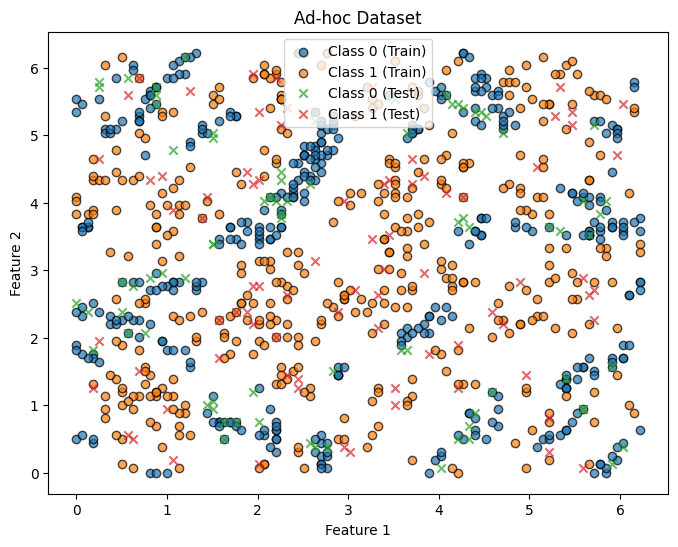

Training data shape: (800, 2)
Testing data shape: (160, 2)
Class labels: [[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0. -1. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [12]:


# Define parameters for the dataset
feature_dim = 2 # Feature dimension (number of qubits)
trainingsize = 400  # Number of training samples
testsize = 80  # Number of testing samples
gap = 0.3  # Gap between the data classes

# Generate the ad-hoc dataset
xtrain, ytrain, xtest, ytest, classlabels = ad_hoc_data(
    training_size=trainingsize,
    test_size=testsize,
    n=feature_dim,
    gap=gap,
    plot_data=False,  # Suppress automatic plotting; we will handle it manually
    one_hot=False,
    include_sample_total=True
)

# Plot the generated dataset
plt.figure(figsize=(8, 6))
plt.scatter(xtrain[ytrain == 0, 0], xtrain[ytrain == 0, 1], label="Class 0 (Train)", alpha=0.7, edgecolor='k')
plt.scatter(xtrain[ytrain == 1, 0], xtrain[ytrain == 1, 1], label="Class 1 (Train)", alpha=0.7, edgecolor='k')
plt.scatter(xtest[ytest == 0, 0], xtest[ytest == 0, 1], label="Class 0 (Test)", marker="x", alpha=0.7)
plt.scatter(xtest[ytest == 1, 0], xtest[ytest == 1, 1], label="Class 1 (Test)", marker="x", alpha=0.7)
plt.title("Ad-hoc Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Print dataset details
print("Training data shape:", xtrain.shape)
print("Testing data shape:", xtest.shape)
print("Class labels:", classlabels)

In [13]:
feature_dim = xtrain.shape[1]  # Dimensionality after PCA
reps = 1# Number of repetitions in the feature map

results = train_and_evaluate_qsvm(
    xs_train=xtrain,
    xs_test=xtest,
    y_train=ytrain,
    y_test=ytest,
    feature_dim=feature_dim,
    reps=reps,
)

print(f"QSVM Accuracy: {results['accuracy']:.4f}")
print("Classification Report:")
print(results['classification_report'])

/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_9533/3089154096.py:22: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/var/folders/8n/5y209hpd0dq56l8hhhtwg25c0000gn/T/ipykernel_9533/3089154096.py:25: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=ComputeUncompute(sampler=sampler))


QSVM Accuracy: 0.9187
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        80
           1       0.96      0.88      0.92        80

    accuracy                           0.92       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.92      0.92      0.92       160



In [14]:
# Train and evaluate classical SVM
classical_results = classical_svm(xtrain,xtest, ytrain, ytest)
print("Classical SVM Results:")
print(f"Accuracy: {classical_results['accuracy']:.4f}")
print(f"Training Time: {classical_results['training_time']:.4f} seconds")
print(classical_results['classification_report'])


Classical SVM Results:
Accuracy: 0.6188
Training Time: 0.0150 seconds
{'0': {'precision': 0.6091954022988506, 'recall': 0.6625, 'f1-score': 0.6347305389221557, 'support': 80.0}, '1': {'precision': 0.6301369863013698, 'recall': 0.575, 'f1-score': 0.6013071895424836, 'support': 80.0}, 'accuracy': 0.61875, 'macro avg': {'precision': 0.6196661943001103, 'recall': 0.6187499999999999, 'f1-score': 0.6180188642323197, 'support': 160.0}, 'weighted avg': {'precision': 0.6196661943001102, 'recall': 0.61875, 'f1-score': 0.6180188642323197, 'support': 160.0}}


# Conclusion and Outlook

## Conclusion

In this experiment, the Quantum Support Vector Machine (QSVM) demonstrated **superior performance** compared to the classical SVM on the higher-dimensional ad-hoc dataset. The results highlight the potential advantages of QSVM for tasks involving non-linear, complex datasets where quantum feature maps, such as the **ZZFeatureMap**, can effectively capture intricate relationships between features. However, if the dataset is only a higher-dimensional dataset, QSVM can't endure a higher accuracy than the Classical SVM.

1. **Enhanced Non-Linear Classification**:  
   QSVM exhibited a significant improvement in handling non-linear relationships in datasets with high-dimensional features. While it does not always guarantee higher accuracy compared to classical SVM, QSVM effectively leveraged the quantum kernel to capture complex patterns in the data, particularly where classical kernels like RBF struggled.

2. **Expressive Quantum Feature Maps**:  
   By encoding data into the Hilbert space, QSVM could distinguish non-linear class boundaries in a more expressive feature space. This capability becomes more pronounced with high-dimensional features and intricate relationships.

   The quantum kernel computes the similarity between two data points $x_i$ and $x_j$ in the feature space as:
   $$
   K(x_i, x_j) = |\langle \psi(x_i) | \psi(x_j) \rangle|^2
   $$
   where:
   - $\psi(x)$ represents the quantum state encoding of the data point $x$.
   - $\langle \cdot | \cdot \rangle$ is the inner product in the quantum Hilbert space.

   The ability of quantum kernels to map data into high-dimensional Hilbert space allows QSVM to capture non-linear patterns more effectively than classical kernels, such as RBF:
   $$
   K_{\text{RBF}}(x_i, x_j) = \exp\left(-\gamma \|x_i - x_j\|^2\right).
   $$

3. **Quantum Advantage in Feature Interactions**:  
   QSVM shows a marked advantage in datasets with complex, entangled feature relationships. The **ZZFeatureMap** encodes interactions between features in a way that classical kernels cannot easily replicate, offering a unique advantage in high-dimensional and non-linear scenarios. However, the overall accuracy improvement may vary depending on the dataset complexity and the quantum feature map's suitability.

## Outlook

### Scalability
QSVM computation scales poorly with increasing dataset size due to the quadratic growth in kernel matrix evaluations. For a dataset with $n$ samples:
$$
T_{\text{Kernel Computation}} = O(n^2 \cdot d),
$$
where $d$ is the feature dimension. While quantum hardware offers theoretical speedups, current simulations are constrained by classical hardware. Future advancements in quantum processors may alleviate these bottlenecks, enabling QSVM to handle larger datasets efficiently.

### Feature Dimension and Quantum Hardware
The performance of QSVM depends on encoding data into a high-dimensional quantum feature space. The number of qubits required scales with the feature dimension:
$$
\text{Number of Qubits} = d.
$$
Applying QSVM to high-dimensional datasets on real quantum devices will provide insights into its true capabilities and potential quantum advantage over classical models.

### Application to Real-World Data
While the ad-hoc dataset serves as a synthetic benchmark, QSVM should be applied to real-world problems, such as:
- **Quantum Chemistry**: Predicting molecular properties.
- **Finance**: Portfolio optimization or fraud detection.
- **Healthcare**: Disease classification from complex diagnostic data.

These applications often involve datasets with intricate non-linear relationships that quantum feature maps are well-suited to handle.

### Hybrid Approaches
Combining quantum kernels with classical deep learning or hybrid quantum-classical models could unlock additional advantages. For example, quantum kernels can preprocess data for a classical neural network, leveraging the strengths of both paradigms.

---


## Final Thoughts and notes
This study reinforces the potential of QSVM in tackling problems that demand expressive feature mapping. Although challenges remain—primarily related to hardware limitations and scalability—QSVM provides a compelling glimpse into the future of quantum machine learning. With continued progress in quantum computing, QSVM could evolve into a powerful tool for solving previously intractable machine learning problems.

This notebook is restrained by the computability of quantumcomputer simulator, you may notice that it takes thousands of times for qsvm to run on a local computer, this is caused by the complexity of a quantum algorithm simulator.

The reason why I am not using a IBM qubit is that my account is judged as a suspicious one and got banned.

###

# References

1. **Quantum Kernel Tutorial**  
   Learn about quantum kernel methods and their applications in machine learning.  
   [Quantum Kernel Machine Learning Tutorial](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/03_quantum_kernel.html)

2. **Introduction to Quantum Support Vector Machines**  
   A detailed introduction to the concepts behind QSVM, with examples.  
   [Quantum Support Vector Machine - Medium](https://medium.com/mit-6-s089-intro-to-quantum-computing/quantum-support-vector-machine-qsvm-134eff6c9d3b)

3. **Qiskit Aer Simulator Documentation**  
   Detailed API reference for Qiskit Aer simulators, including the QasmSimulator.  
   [QasmSimulator API Documentation](https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.QasmSimulator.html)

4. **QSVM Introduction Jupyter Notebook**  
   An introductory notebook explaining QSVM implementation in Python.  
   [QSVM Introduction GitHub Repository](https://github.com/PatrickHuembeli/QSVM-Introduction/blob/master/Quantum%20Support%20Vector%20Machines.ipynb)

5. **Qiskit Quantum Instance Migration Guide**  
   Migration guide for users transitioning from `QuantumInstance` to the new primitives-based interface in Qiskit.  
   [Qiskit Quantum Instance Migration Guide](https://docs.quantum.ibm.com/migration-guides/qiskit-quantum-instance)

6. **IBM Quantum Documentation**  
   The official IBM Quantum documentation, including hardware and software guides.  
   [IBM Quantum Documentation](https://docs.quantum.ibm.com/)
